## 1. Imports & Setup

Initializes libraries, model classes, and tools. Sets plotting style and ensures the model directory exists.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import glob
import re

# Models
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Sklearn Tools
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression

# Setup plotting
sns.set_style("whitegrid")

# Create models folder if it doesn't exist
if not os.path.exists("../../models"):
    os.makedirs("../../models")

## 2. Load & Preprocess Data

Loads the cleaned dataset

In [11]:
# FIND FILE AUTOMATICALLY
files = glob.glob("../Datasets/Cleaned_Datasets/Marketing/*.csv")
print(f"Loading file: {files[0]}")
df = pd.read_csv(files[0])
print(f"Final Data Shape: {df.shape}")

Loading file: ../Datasets/Cleaned_Datasets/Marketing\marketing_cleaned_prepared.csv
Final Data Shape: (72206, 21)


## 3. Feature Engineering & Selection

Defines the target variable, removes potential data leakage, splits the data, and selects the top 10 most relevant features.

✅ Input Features: 15
🗑️ Dropped Leakage: ['overcost', 'campaign_item_id', 'media_cost_usd', 'clicks', 'impressions', 'Unnamed: 0']

🔍 Training Inspector Models to compare Feature Importance...
   -> Analyzing with RandomForest...
   -> Analyzing with XGBoost...
   -> Analyzing with LightGBM...


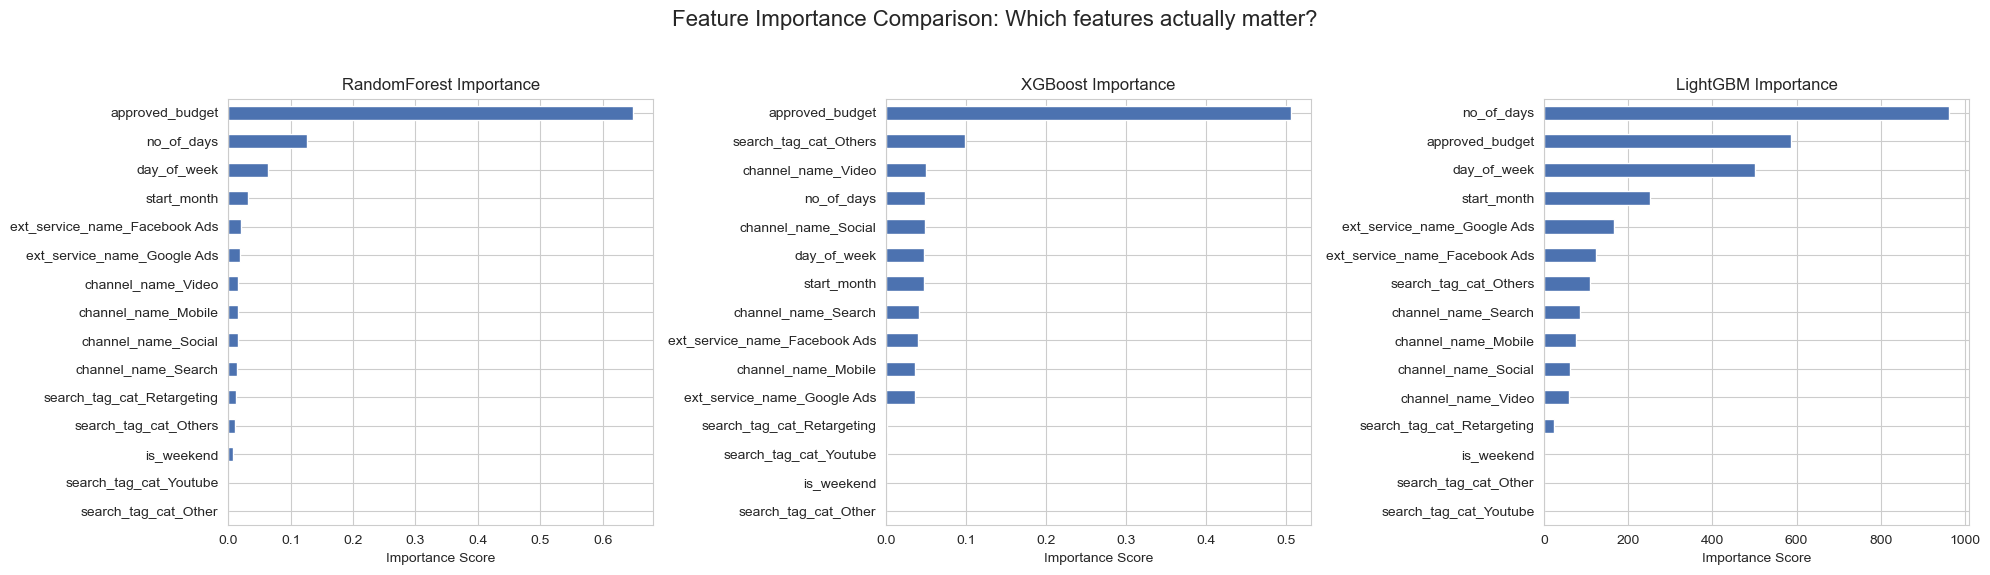

✅ Visualization Complete.
✅ Selection Complete. Using these features:
['no_of_days', 'approved_budget', 'start_month', 'ext_service_name_Google Ads', 'channel_name_Mobile', 'channel_name_Search', 'search_tag_cat_Other', 'search_tag_cat_Others', 'search_tag_cat_Retargeting', 'search_tag_cat_Youtube']


In [ ]:
# DEFINE TARGET & LEAKAGE
TARGET = 'overcost'

leakage_cols = [
    TARGET,
    'campaign_item_id',
    'campaign_budget_usd',
    'media_cost_usd',
    'clicks', 'impressions',
    'Unnamed: 0', 'Unnamed__0'
]

# safely find which columns to drop
cols_to_drop = [c for c in leakage_cols if c in df.columns]

# Separate Features (X) and Target (y)
X = df.drop(columns=cols_to_drop)
y = df[TARGET]

# ENCODING
# One-Hot Encoding for categorical variables
X = pd.get_dummies(X, drop_first=True).fillna(0)

print(f"✅ Input Features: {X.shape[1]}")
print(f"🗑️ Dropped Leakage: {cols_to_drop}")

# SPLIT & SELECT FEATURES
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# MULTI-MODEL FEATURE IMPORTANCE VISUALIZATION
print("\n🔍 Training Inspector Models to compare Feature Importance...")

# Defining the Inspectors
inspectors = {
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, objective='reg:squarederror', random_state=42),
    'LightGBM': LGBMRegressor(n_estimators=100, random_state=42, verbose=-1)
}

# Setup Plotting (1 Row, 3 Columns)
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Feature Importance Comparison: Which features actually matter?', fontsize=16)

# 3. Loop, Train, and Plot
for i, (name, model) in enumerate(inspectors.items()):
    print(f"   -> Analyzing with {name}...")
    
    # Train
    model.fit(X_train, y_train)
    
    # Extract Importance
    importances = model.feature_importances_
    feat_series = pd.Series(importances, index=X_train.columns)
    
    # Plot Top 15
    ax = axes[i]
    feat_series.nlargest(15).plot(kind='barh', ax=ax, color='#4c72b0')
    
    ax.set_title(f"{name} Importance")
    ax.invert_yaxis()
    ax.set_xlabel("Importance Score")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("✅ Visualization Complete.")

# Select Top 10 Features
selector = SelectKBest(score_func=f_regression, k=10)

# Fit on Train
X_train_sel_array = selector.fit_transform(X_train, y_train)
X_test_sel_array = selector.transform(X_test)

# Get names of selected features
selected_indices = selector.get_support(indices=True)
selected_features = X.columns[selected_indices]

# Convert back to DataFrame
X_train_sel = pd.DataFrame(X_train_sel_array, columns=selected_features, index=X_train.index)
X_test_sel = pd.DataFrame(X_test_sel_array, columns=selected_features, index=X_test.index)

print(f"✅ Selection Complete. Using these features:\n{list(selected_features)}")

## 4. Baseline Model Evaluation

Trains standard models (RandomForest, XGBoost, LightGBM) without optimization to establish a performance baseline. Calculates key metrics R2, RMSE, and Cross-Validation scores to assess initial accuracy.

In [13]:
# 1. Define Baseline Models
models = {
    'RandomForest': RandomForestRegressor(random_state=42), 
    'XGBoost': XGBRegressor(random_state=42, objective='reg:squarederror'),
    'LightGBM': LGBMRegressor(random_state=42, verbose=-1)
}

print("\n📊 MARKET ENGINE BASELINE RESULTS")
print("-" * 115)
print(f"{'Model':<15} | {'Test R2':<10} | {'Train R2':<10} | {'Gap':<10} | {'RMSE':<12} | {'CV Score':<10}")
print("-" * 115)

for name, model in models.items():
    # A. Train
    model.fit(X_train_sel, y_train)
    
    # B. Predict
    y_pred_test = model.predict(X_test_sel)
    y_pred_train = model.predict(X_train_sel)
    
    # C. Calculate Standard Metrics
    r2_test = r2_score(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    gap = r2_train - r2_test
    
    # D. Calculate Cross-Validation Score
    cv_scores = cross_val_score(model, X_train_sel, y_train, cv=5, scoring='r2')
    cv_avg = cv_scores.mean()
    
    # E. Print (RMSE formatted as Currency for Overcost)
    print(f"{name:<15} | {r2_test:.4f}     | {r2_train:.4f}     | {gap:.4f}     | ${rmse:,.0f}    | {cv_avg:.4f}")

print("-" * 115)


📊 MARKET ENGINE BASELINE RESULTS
-------------------------------------------------------------------------------------------------------------------
Model           | Test R2    | Train R2   | Gap        | RMSE         | CV Score  
-------------------------------------------------------------------------------------------------------------------
RandomForest    | 0.5189     | 0.8511     | 0.3322     | $83,630    | 0.5097
XGBoost         | 0.4050     | 0.8401     | 0.4351     | $93,000    | 0.4393
LightGBM        | 0.5587     | 0.7225     | 0.1638     | $80,090    | 0.5783
-------------------------------------------------------------------------------------------------------------------


## 5. Hyperparameter Optimization

Performs Randomized Search Cross-Validation to fine-tune hyperparameters for each model. Evaluates the optimized models on Test data and automatically selects the best performer based on the Test R2 Score.

In [14]:
from sklearn.model_selection import RandomizedSearchCV

# 1. Define Parameter Grids
param_grids = {
    'RandomForest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10]
    },
    'XGBoost': {
        'n_estimators': [100, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0]
    },
    'LightGBM': {
        'n_estimators': [100, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'num_leaves': [31, 50]
    }
}

print("\n⚡ OPTIMIZATION RESULTS (MARKET ENGINE)")
print("-" * 115)
print(f"{'Model':<15} | {'Test R2':<10} | {'Train R2':<10} | {'Gap':<10} | {'RMSE':<12} | {'CV Score':<10}")
print("-" * 115)

# Variables to track the "Best of the Best" for saving
best_opt_r2 = -float('inf')
best_opt_model = None
best_model_name = None 
best_opt_rmse = 0

# 2. LOOP THROUGH ALL MODELS
for name, model in models.items():
    if name in param_grids:
        # A. Setup Search
        search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_grids[name],
            n_iter=5,
            cv=3, 
            scoring='r2', 
            n_jobs=-1, 
            random_state=42
        )
        
        # B. Fit (USING SELECTED FEATURES)
        search.fit(X_train_sel, y_train)
        
        # C. Get Best Optimized Model
        opt_model = search.best_estimator_
        
        # D. Predict
        y_pred_test = opt_model.predict(X_test_sel)
        y_pred_train = opt_model.predict(X_train_sel)
        
        # E. Calculate Metrics
        r2_test = r2_score(y_test, y_pred_test)
        r2_train = r2_score(y_train, y_pred_train)
        gap = r2_train - r2_test
        rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
        cv_score = search.best_score_
        
        # F. Print Row (RMSE is Currency for Market Engine)
        print(f"{name:<15} | {r2_test:.4f}     | {r2_train:.4f}     | {gap:.4f}     | ${rmse:,.0f}    | {cv_score:.4f}")
        
        # G. Track the ultimate winner
        if r2_test > best_opt_r2:
            best_opt_r2 = r2_test
            best_opt_rmse = rmse
            best_opt_model = opt_model
            best_model_name = name

print("-" * 115)
print(f"🏆 Ultimate Winner: {best_model_name} (R2: {best_opt_r2:.4f})")
# Save these for the file saver later
opt_r2 = best_opt_r2
opt_rmse = best_opt_rmse


⚡ OPTIMIZATION RESULTS (MARKET ENGINE)
-------------------------------------------------------------------------------------------------------------------
Model           | Test R2    | Train R2   | Gap        | RMSE         | CV Score  
-------------------------------------------------------------------------------------------------------------------
RandomForest    | 0.5728     | 0.7540     | 0.1812     | $78,806    | 0.5786
XGBoost         | 0.6083     | 0.6635     | 0.0553     | $75,461    | 0.6189
LightGBM        | 0.5838     | 0.7014     | 0.1175     | $77,780    | 0.5869
-------------------------------------------------------------------------------------------------------------------
🏆 Ultimate Winner: XGBoost (R2: 0.6083)


## 6. Feature Importance Visualization

Extracts and visualizes the top 5 most influential features for each model. This step show exactly which data points the models are prioritizing for their predictions.


Training RandomForest...
✅ RandomForest Top 5 Features:
                      Feature  Importance
              approved_budget    0.648144
                   no_of_days    0.125570
                  day_of_week    0.063276
                  start_month    0.030888
ext_service_name_Facebook Ads    0.019843


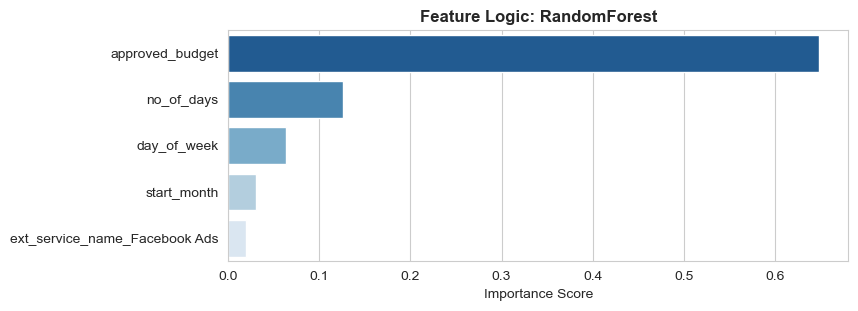

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬

Training XGBoost...
✅ XGBoost Top 5 Features:
              Feature  Importance
      approved_budget    0.506211
search_tag_cat_Others    0.098484
   channel_name_Video    0.049419
           no_of_days    0.048670
  channel_name_Social    0.048262


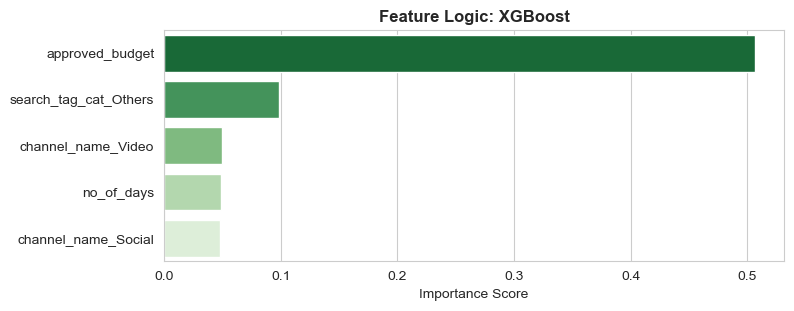

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬

Training LightGBM...
✅ LightGBM Top 5 Features:
                    Feature  Importance
                 no_of_days         962
            approved_budget         586
                day_of_week         500
                start_month         252
ext_service_name_Google Ads         165


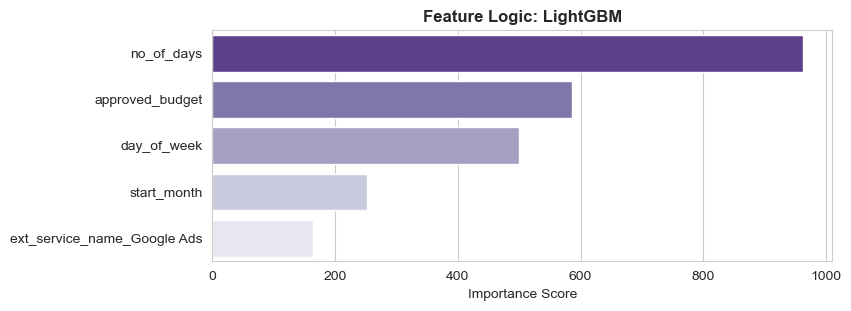

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬


In [15]:
# 2. Loop through each model to Train & Visualize
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # A. Train the model fresh
    model.fit(X_train, y_train)
    
    # B. Extract Feature Importance
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feature_names = X_train.columns
        
        # Create a clean DataFrame
        feat_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False).head(5) # Keep top 5
        
        # C. Print the Numbers (The "Evidence")
        print(f"✅ {name} Top 5 Features:")
        print(feat_df.to_string(index=False))
        
        # D. Plot the Graph (The "Visual")
        plt.figure(figsize=(8, 3))
        # Color coding: RF=Blue, XGB=Green, LGBM=Purple for distinctness
        color_map = {'RandomForest': 'Blues_r', 'XGBoost': 'Greens_r', 'LightGBM': 'Purples_r'}
        
        sns.barplot(x='Importance', y='Feature', hue='Feature', data=feat_df, palette=color_map[name], legend=False)
        plt.title(f'Feature Logic: {name}', fontsize=12, fontweight='bold')
        plt.xlabel('Importance Score')
        plt.ylabel('')
        plt.show()
        print("▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬")
    else:
        print(f"⚠️ Model {name} does not support feature importance.")

## 7. Prediction Evaluation

Selects the best performing model and validates its value by comparing it against a "Naive Baseline" (simply guessing the average conversion rate for everyone).

In [16]:
# 1. Select the Best Model
# Prioritize the Optimized model, fallback to the Baseline winner
if 'best_opt_model' in locals():
    final_model = best_opt_model
    model_name = best_model_name
    print(f"✅ Evaluating Optimized Model: {model_name}")
elif 'best_model' in locals():
    final_model = best_model
    model_name = best_name
    print(f"✅ Evaluating Baseline Model: {model_name}")
else:
    final_model = list(models.values())[0]
    print("⚠️ Evaluating: First Model (Winner not found)")

# 2. Get Predictions (on Selected Features)
y_pred = final_model.predict(X_test_sel)

# --- THE BASELINE TEST (The "Duck Test") ---
# Logic: "If I just assumed we would hit the budget perfectly (Overcost = 0), how wrong would I be?"
baseline_preds = np.zeros(len(y_test)) # Baseline = Predicting 0 Overcost every time

baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_preds))
model_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
improvement = baseline_rmse - model_rmse

print(f"\n📊 Baseline Comparison (The 'Duck Test'):")
print(f"   1. Baseline RMSE (Assuming Cost = Budget): ${baseline_rmse:,.0f}")
print(f"   2. AI Model RMSE (Your Prediction):        ${model_rmse:,.0f}")
print(f"   ------------------------------------------------------")

if improvement > 0:
    print(f"   ✅ SUCCESS: Your AI beats the baseline by ${improvement:,.0f}!")
else:
    print(f"   ❌ FAIL: The AI is worse than just guessing 0.")

✅ Evaluating Optimized Model: XGBoost

📊 Baseline Comparison (The 'Duck Test'):
   1. Baseline RMSE (Assuming Cost = Budget): $122,469
   2. AI Model RMSE (Your Prediction):        $75,461
   ------------------------------------------------------
   ✅ SUCCESS: Your AI beats the baseline by $47,008!


## 8. Save Model

Persists the final, best performing model to a .joblib file. The filename is automatically versioned with the model type, its R2 accuracy score, and a timestamp to ensure reproducibility and easy tracking of experiments.

In [17]:
#show all columns in order
pd.set_option('display.max_columns', None)
print(X.head())

   no_of_days  approved_budget  start_month  day_of_week  is_weekend  \
0           7            400.0            5            6           1   
1           8            400.0            5            0           0   
2           9            400.0            5            1           0   
3          10            400.0            5            2           0   
4          11            400.0            5            3           0   

   ext_service_name_Facebook Ads  ext_service_name_Google Ads  \
0                              1                            0   
1                              0                            0   
2                              1                            0   
3                              1                            0   
4                              0                            1   

   channel_name_Mobile  channel_name_Search  channel_name_Social  \
0                    1                    0                    0   
1                    0                  

In [18]:
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d_%H%M")

if 'best_opt_model' in locals():
    filename = f"Marketing_Model_{best_model_name}_Opt_R2-{opt_r2:.3f}_{timestamp}.joblib"
    save_dir = "../Model_Training/Trained_Models/Marketing"
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        
    save_path = os.path.join(save_dir, filename)
    joblib.dump(best_opt_model, save_path)
    print(f"✅ Saved Marketing Campaigns Model: {save_path}")
else:
    print("❌ optimization didn't run.")

✅ Saved Marketing Campaigns Model: ../Model_Training/Trained_Models/Marketing\Marketing_Model_XGBoost_Opt_R2-0.608_20260117_1752.joblib
